<a href="https://colab.research.google.com/github/MakovChen/SideProject-QuantApplication/blob/main/Metatrader5%E4%BA%A4%E6%98%93%E7%A5%9E%E5%99%A8ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests, random
import pandas as pd
import tensorflow.compat.v1 as tf
from tensorflow.python.saved_model import tag_constants
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def get_data(api_key, from_currency, to_currency):
    url = f"https://www.alphavantage.co/query?function=FX_DAILY&from_symbol={from_currency}&to_symbol={to_currency}&apikey={api_key}&outputsize=full"
    response = requests.get(url)
    data = response.json()
    forex_data = data['Time Series FX (Daily)']
    data_dict = {"Datetime": [], "Open": [], "High": [], "Low": [], "Close": []}
    for date, values in forex_data.items():
        O, H, C, L = values['1. open'], values['2. high'], values['3. low'], values['4. close']
        data_dict['Datetime'].append(date); data_dict["Open"].append(O); data_dict["High"].append(H); data_dict["Low"].append(L); data_dict["Close"].append(C)
    temp_df = pd.DataFrame(data_dict)
    temp_df['Datetime'], temp_df["Open"], temp_df["High"], temp_df["Low"], temp_df["Close"] = pd.to_datetime(temp_df['Datetime']), pd.to_numeric(temp_df["Open"]), pd.to_numeric(temp_df["High"]), pd.to_numeric(temp_df["Low"]), pd.to_numeric(temp_df["Close"])
    temp_df = temp_df.sort_values('Datetime')
    return temp_df.set_index('Datetime')

#多單交易回報模擬
def Open_Bull_Sheet(temp_df, asset, profit_ratio = 1.5, parts = 0.05, leverage = 75):
    fund = asset * parts
    entry_price = np.clip(np.random.normal(temp_df.Close[0], (temp_df.High[0] - temp_df.Low[0])/3, 1)[0], temp_df.High[0], temp_df.Low[0])
    position = float("{:.2f}".format(fund * leverage / 100000 / entry_price))
    stop_loss =  round(-(fund / 100000 / position) + entry_price, 5)
    stop_earn =  round(entry_price + (entry_price - stop_loss) * profit_ratio, 4)
    exist_point = {'High': stop_earn, 'Low': stop_loss}
    flag = False
    #plt.figure(figsize=[15, 3]); plt.plot(list(temp_df.Low)[:60]); plt.plot(list(temp_df.High)[:60]); plt.plot([0, 60],[stop_earn, stop_earn]); plt.plot([0, 60],[stop_loss, stop_loss]); plt.show()
    for i in range(1, temp_df.shape[0] - 1):
        current_price = temp_df.High[i]
        if temp_df.High[i] > exist_point['High'] or temp_df.Low[i] < exist_point['Low']:
            flag = True; break
        elif (current_price - entry_price) > (stop_earn - entry_price) * 0.5:
            exist_point['Low'] = entry_price + (stop_earn - entry_price) * 0.218
        elif (current_price - entry_price) > (stop_earn - entry_price) * 0.618:
            exist_point['Low'] = entry_price + (stop_earn - entry_price) * 0.382
        elif (current_price - entry_price) > (stop_earn - entry_price) * 0.782:
            exist_point['Low'] = entry_price + (stop_earn - entry_price) * 0.5
    exist_price = max([temp_df.Low[i], exist_point['Low']]) if temp_df.Low[i] < exist_point['Low'] else min([temp_df.High[i], exist_point['High']])
    profit = (exist_price - entry_price) * 100000 * position
    #print('可用資金:', fund, '當前價格', entry_price, '可下口數:', position, '停損價格', stop_loss, '停利價格', stop_earn)
    return profit, profit > 0, flag, i

def Sheet(entry_price, asset, profit_ratio = 1.5, parts = 0.05, leverage = 75):
    fund = asset * parts
    position = float("{:.2f}".format(fund * leverage / 100000 / entry_price))
    stop_loss =  round(-(fund / 100000 / position) + entry_price, 5)
    stop_earn =  round(entry_price + (entry_price - stop_loss) * profit_ratio, 4)
    exist_point = {'High': stop_earn, 'Low': stop_loss}
    stop_earn218 = round(entry_price + (stop_earn - entry_price) * 0.218, 5)
    stop_earn382 = round(entry_price + (stop_earn - entry_price) * 0.382, 5)
    stop_earn5 = round(entry_price + (stop_earn - entry_price) * 0.5, 5)
    stop_earn618 = round(entry_price + (stop_earn - entry_price) * 0.618, 5)
    stop_earn782 = round(entry_price + (stop_earn - entry_price) * 0.782, 5)
    return entry_price, position, stop_loss, stop_earn, stop_earn218, stop_earn382, stop_earn5, stop_earn618, stop_earn782

def sampling(temp_df, parts, asset_given = 500):
    p, f = [], []
    for _ in range(30):
        profit, flag = Open_Bull_Sheet(temp_df, asset_given, parts)
        p.append(profit), f.append(flag)
    avg_profit, win_prob = np.mean(p), np.mean(f)
    return avg_profit, win_prob

In [5]:
def test(test_df):
  history = []
  asset_update = 500
  win, loss, i = 0, 0, 0
  while i < test_df.shape[0] - 2:
      if test_df.Pos[i] > 0.8 and test_df.Neg[i] < 0.2:
          profit, _, _, delay = Open_Bull_Sheet(test_df.iloc[i:, :], asset_update, profit_ratio = 1.5, parts = 0.15, leverage = 75)
          asset_update += profit
          if profit > 0:
              win += 1
          else:
              loss += 1
          i += delay - 1
      history.append(asset_update)
      i += 1
  plt.figure(figsize=[15, 3]); plt.plot(history); plt.show()
  print('【模型版本 年化報酬', asset_update * 100/ 500 - 100,'% (勝率',round(win * 100/ (win + loss) , 2),'%, 交易', win + loss, '次)】')

def get_prediction(target, version, timestep, timestep_inv, balance, ohlc_scale_rate, ohlc_scale_rate_n, ohlc_scale_rate_inv, ohlc_scale_rate_n_inv):
    df = get_data('BG6KLRFVZIPNDFYP', target, 'USD')
    df_inv = get_data('BG6KLRFVZIPNDFYP', 'USD', target)
    #蒐集驗證樣本
    X, Xn, t = [], [], []
    for i in range(df.shape[0] - timestep - 2):
        if df.index[i + timestep] < pd.to_datetime("2023-06-21") and df.index[i + timestep] > pd.to_datetime("2022-07-07"):
            series_df = df.loc[:, ['Open', 'High', 'Low', 'Close']].iloc[i: i + timestep, :].copy()
            series = np.array(series_df).flatten()
            x_p = np.array(np.degrees((series / series[0] - 1) * ohlc_scale_rate).astype(int) + 180 - 1)
            x_n = np.array(np.degrees((series / series[-1] - 1) * ohlc_scale_rate_n).astype(int) + 180 - 1)
            X.append(np.concatenate((x_p, x_n)))

            series = np.array(df_inv.loc[:series_df.index[-1], ['Open', 'High', 'Low', 'Close']].iloc[-timestep_inv:, :].copy()).flatten()
            x_p = np.array(np.degrees((series / series[0] - 1) * ohlc_scale_rate_inv).astype(int) + 180 - 1)
            x_n = np.array(np.degrees((series / series[-1] - 1) * ohlc_scale_rate_n_inv).astype(int) + 180 - 1)
            Xn.append(np.concatenate((x_p, x_n)))

            t.append(df.index[i + timestep])

    graph = tf.Graph()
    with graph.as_default():
        with tf.Session(graph=graph) as sess:
            loaded_model = tf.saved_model.loader.load(sess, [tag_constants.SERVING], '/content/drive/My Drive/' + target + '_server/model_' + version)
            Input = graph.get_tensor_by_name('X:0')
            Output = graph.get_tensor_by_name('dense_8/Softmax:0')
            #模型預測與價值估算
            y_pred =  sess.run(Output, {Input: np.array(X)})

            #實際預測
            series = np.array(df.loc[:, ['Open', 'High', 'Low', 'Close']].iloc[-timestep: , :]).flatten()
            x_p = np.array(np.degrees((series / series[0] - 1) * ohlc_scale_rate).astype(int) + 180 - 1)
            x_n = np.array(np.degrees((series / series[-1] - 1) * ohlc_scale_rate_n).astype(int) + 180 - 1)
            x_real = np.concatenate((x_p, x_n))
            prob = sess.run(Output, {Input: np.array([x_real])})[0][1]

    graph = tf.Graph()
    with graph.as_default():
        with tf.Session(graph=graph) as sess:
            loaded_model = tf.saved_model.loader.load(sess, [tag_constants.SERVING], '/content/drive/My Drive/' + target + 'n_server/model_' + version)
            Input = graph.get_tensor_by_name('X:0')
            Output = graph.get_tensor_by_name('dense_8/Softmax:0')
            #模型預測與價值估算
            y_pred_n =  sess.run(Output, {Input: np.array(Xn)})

            #實際預測
            series = np.array(df_inv.loc[:, ['Open', 'High', 'Low', 'Close']].iloc[-timestep_inv: , :]).flatten()
            x_p = np.array(np.degrees((series / series[0] - 1) * ohlc_scale_rate_inv).astype(int) + 180 - 1)
            x_n = np.array(np.degrees((series / series[-1] - 1) * ohlc_scale_rate_n_inv).astype(int) + 180 - 1)
            x_real_n = np.concatenate((x_p, x_n))
            prob_n = sess.run(Output, {Input: np.array([x_real_n])})[0][1]

    temp_df = df.copy().loc["2022-07-07":"2023-06-21", :]
    temp_df['Pos'] = 0; temp_df['Neg'] = 0
    for i, j, k in zip(t, y_pred[:,1], y_pred_n[:,1]):
        temp_df['Pos'][i], temp_df['Neg'][i] = j, k

    test(temp_df)

    entry_price, position, stop_loss, stop_earn, stop_earn218, stop_earn382, stop_earn5, stop_earn618, stop_earn782 = Sheet(df.Close[-1], balance)
    print(df.index[-1], target, '當前價格', entry_price, '可下口數:', position, "(多:",prob,"空:",prob_n,")")
    if prob > 0.8 and prob_n < 0.2:
        print('>>> 停損價格', stop_loss)
        print('>>> 100% 停利價格', stop_earn)
        print('>>> 抵達', stop_earn5, '停利價格(Tradingview設定通知)', stop_earn218)
        print('>>> 抵達', stop_earn618, '停利價格(Tradingview設定通知)', stop_earn382)
        print('>>> 抵達', stop_earn782, '停利價格(Tradingview設定通知)', stop_earn5)

<ipython-input-5-5157c38897d2>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['Pos'][i], temp_df['Neg'][i] = j, k


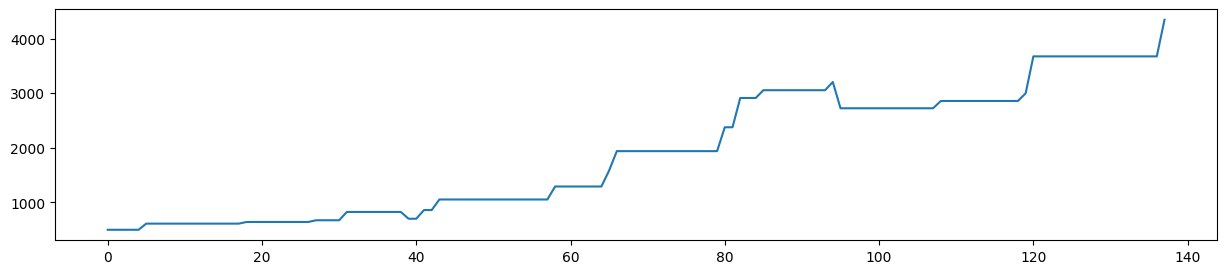

【模型版本 年化報酬 768.5963239999988 % (勝率 89.47 %, 交易 19 次)】
2023-07-07 00:00:00 EUR 當前價格 1.08668 可下口數: 3.45 (多: 0.9076435 空: 0.9626542 )


In [6]:
balance = 100000
get_prediction('EUR', '2022-07-06', 7, 14, balance = balance, ohlc_scale_rate = 22.64820225337517, ohlc_scale_rate_n = 32.22354062072263, ohlc_scale_rate_inv = 36.45988202325782, ohlc_scale_rate_n_inv = 39.8697516408773)